In [3]:
def load_UCL_OPM(raw_name, chan_name, json_file, pos_file):
    # Import the necessary packages
    import numpy as np
    import matplotlib.pyplot as plt
    import mne
    import pandas as pd
    import json

    # Load 1D data from .bin file
    d = np.fromfile(raw_name,'>f4')
    
    print('Data loaded as: ' + str(d.dtype))
    
    # Load tsv channels file
    tsv = pd.read_csv(chan_name,sep='\t')
    
    # Replace the channel types with a
    tsv['type'] = tsv['type'].replace('MEGMAG','mag')
    tsv['type'] = tsv['type'].replace('TRIG','stim')
    tsv['type'] = tsv['type'].replace('REF','ref_meg')
    
    # Replace Flux channels with misc
    tsv.loc[tsv.name.str.contains('Flux'), 'type'] = 'misc'
    
    # Put these into a list
    chans = tsv['name'].values.tolist()
    types = tsv['type'].values.tolist()
    
    # Open the _meg.json and extract the sampling freq
    with open(chan_json) as json_file:
        json_meg = json.load(json_file)

    Fs = json_meg['SamplingFrequency']
    
#     # Make a montage
#     pos_tsv = pd.read_csv(pos_file,sep='\t')

#     dict = {}

#     for e in np.arange(0,len(pos_tsv)):
#         dict[pos_tsv.name[e]] = np.array([pos_tsv.Px[e]/1000,pos_tsv.Py[e]/1000,pos_tsv.Pz[e]/1000])

#     montage_opm = mne.channels.make_dig_montage(ch_pos=dict,coord_frame='mri')
    
    # Create MNE info field
    inf = mne.create_info(chans, Fs, ch_types = types, verbose=None)
    
    # Reshape the 1D data into 2D based on the number of channels present
    d2 = np.reshape(d, [len(chans), int(len(d)/len(chans))],'F')
    
    # Create raw MNE object
    raw = mne.io.RawArray(d2, inf, first_samp=0, copy='auto', verbose=None)
    
    return raw
    

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import json
import os.path as op
from mne.io import read_raw_fif

In [5]:
%matplotlib qt

In [6]:
# Path to data
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG'
data_dir        = '/Volumes/Robert T5/22_09_2020_benchmarking/'
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/'

In [7]:
raw_name               = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_meg.bin')
raw_emptyroom_name     = op.join(data_dir, 'sub-001/', 'ses-001/','meg/','sub-001_ses-001_task-noise_run-001_meg.bin')
chan_name              = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_channels.tsv')
chan_json              = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_meg.json')
pos_file               = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_positions.tsv')


In [8]:
raw       = load_UCL_OPM(raw_name, chan_name, chan_json, pos_file)
raw_noise = load_UCL_OPM(raw_emptyroom_name, chan_name, chan_json, pos_file)


Data loaded as: >f4
Creating RawArray with float64 data, n_channels=77, n_times=4504140
    Range : 0 ... 4504139 =      0.000 ...   750.690 secs
Ready.
Data loaded as: >f4
Creating RawArray with float64 data, n_channels=77, n_times=1080540
    Range : 0 ... 1080539 =      0.000 ...   180.090 secs
Ready.


In [9]:
raw2 = read_raw_fif('/Volumes/Robert T5/MMF_data_raw.fif')

Opening raw data file /Volumes/Robert T5/MMF_data_raw.fif...
Isotrak not found
    Range : 0 ... 4504139 =      0.000 ...   750.690 secs
Ready.


In [11]:
hsp = mne.channels.read_dig_polhemus_isotrak(fname='/Volumes/Robert T5/NA.hsp',unit='mm')
raw2.set_montage(hsp)


<Raw | MMF_data_raw.fif, 62 x 4504140 (750.7 s), ~1.0 MB, data not loaded>

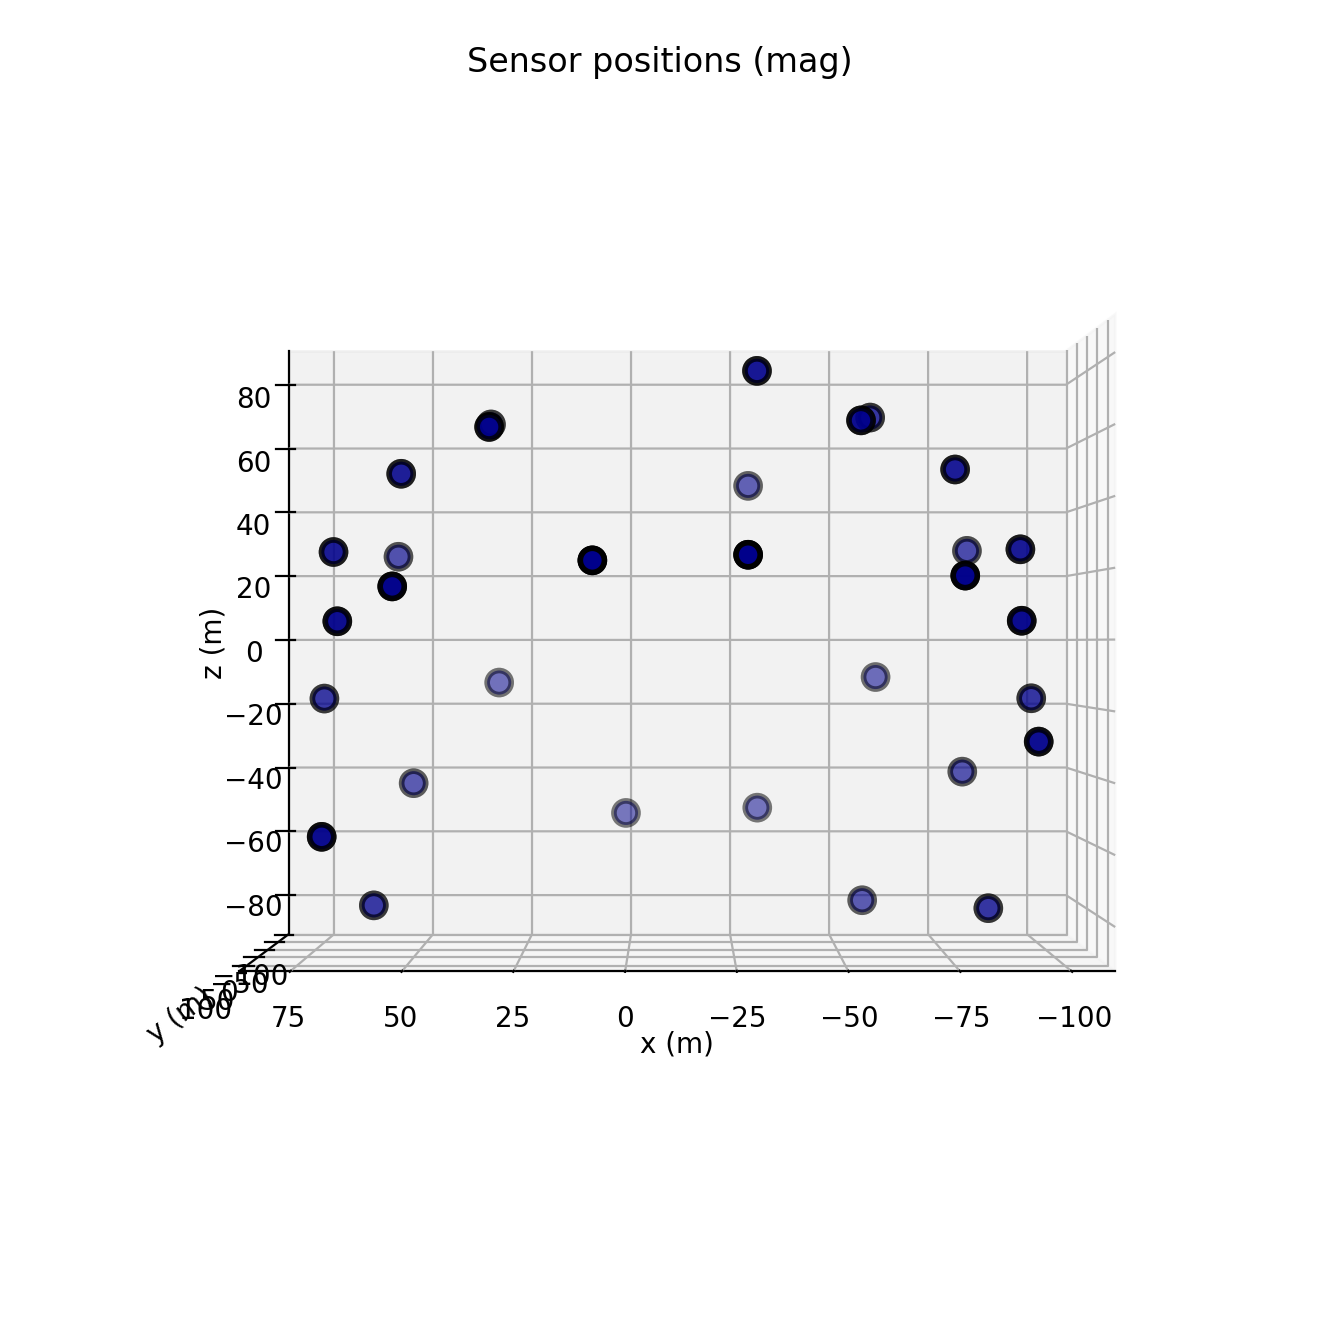

In [12]:
raw_mag = raw.pick_types('mag')
raw_noise = raw_noise.pick_types('mag')

raw_mag.info = raw2.info
raw_noise.info = raw2.info

raw_mag.plot_sensors(kind='3d')

In [13]:
raw_mag.info['bads'] = ['DP-RAD','DP-TAN']
raw_noise.info['bads'] = ['DP-RAD','DP-TAN']

In [14]:
raw_mag = raw_mag.copy().resample(600)
raw_noise = raw_noise.copy().resample(600)

In [15]:
raw_mag.info

<Info | 11 non-empty values
 bads: 2 items (DP-RAD, DP-TAN)
 ch_names: A6-TAN, A6-RAD, 1C-TAN, 1C-RAD, A2-TAN, A2-RAD, A9-TAN, A9-RAD, ...
 chs: 62 MAG
 custom_ref_applied: False
 dig: 1273 items (3 Cardinal, 1270 Extra)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 300.0 Hz
 meas_date: 1970-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 62
 projs: []
 sfreq: 600.0 Hz
>

In [16]:
bemmm = mne.bem.fit_sphere_to_headshape(raw_mag.info, dig_kinds='auto', units='mm', verbose=None)

Fitted sphere radius:         98.0 mm
Origin head coordinates:      -0.4 18.6 33.2 mm
Origin device coordinates:    -0.4 18.6 33.2 mm


In [46]:
ssp1 = mne.compute_proj_raw(raw_noise,n_mag=1)
# mne.viz.plot_projs_topomap(ssp1, colorbar=True, vlim='joint',
#                            info=raw_noise.info)

Not setting metadata
Not setting metadata
180 matching events found
No baseline correction applied
No gradiometers found. Forcing n_grad to 0
Adding projection: axial-Raw-0.000-180.090-PCA-01


In [25]:
np.array([-10, 20.6, 0])/1000

array([-0.01  ,  0.0206,  0.    ])

In [47]:
raw_mag_sss = mne.preprocessing.maxwell_filter(
    raw_mag,origin=np.array([-10, 20.6, 0])/1000, int_order=2, coord_frame='head',extended_proj=ssp1, verbose=True)

Maxwell filtering raw data
60 of 60 magnetometer types replaced with T3.
    Bad MEG channels being reconstructed: ['DP-RAD', 'DP-TAN']
    Processing 0 gradiometers and 62 magnetometers
    Extending external SSS basis using 1 projection vectors
    Using origin -10.0, 20.6, 0.0 mm in the head frame
        Using 18/24 harmonic components for    0.000  (2/8 in, 16/16 out)
    Using loaded raw data
    Processing 75 data chunks
[done]


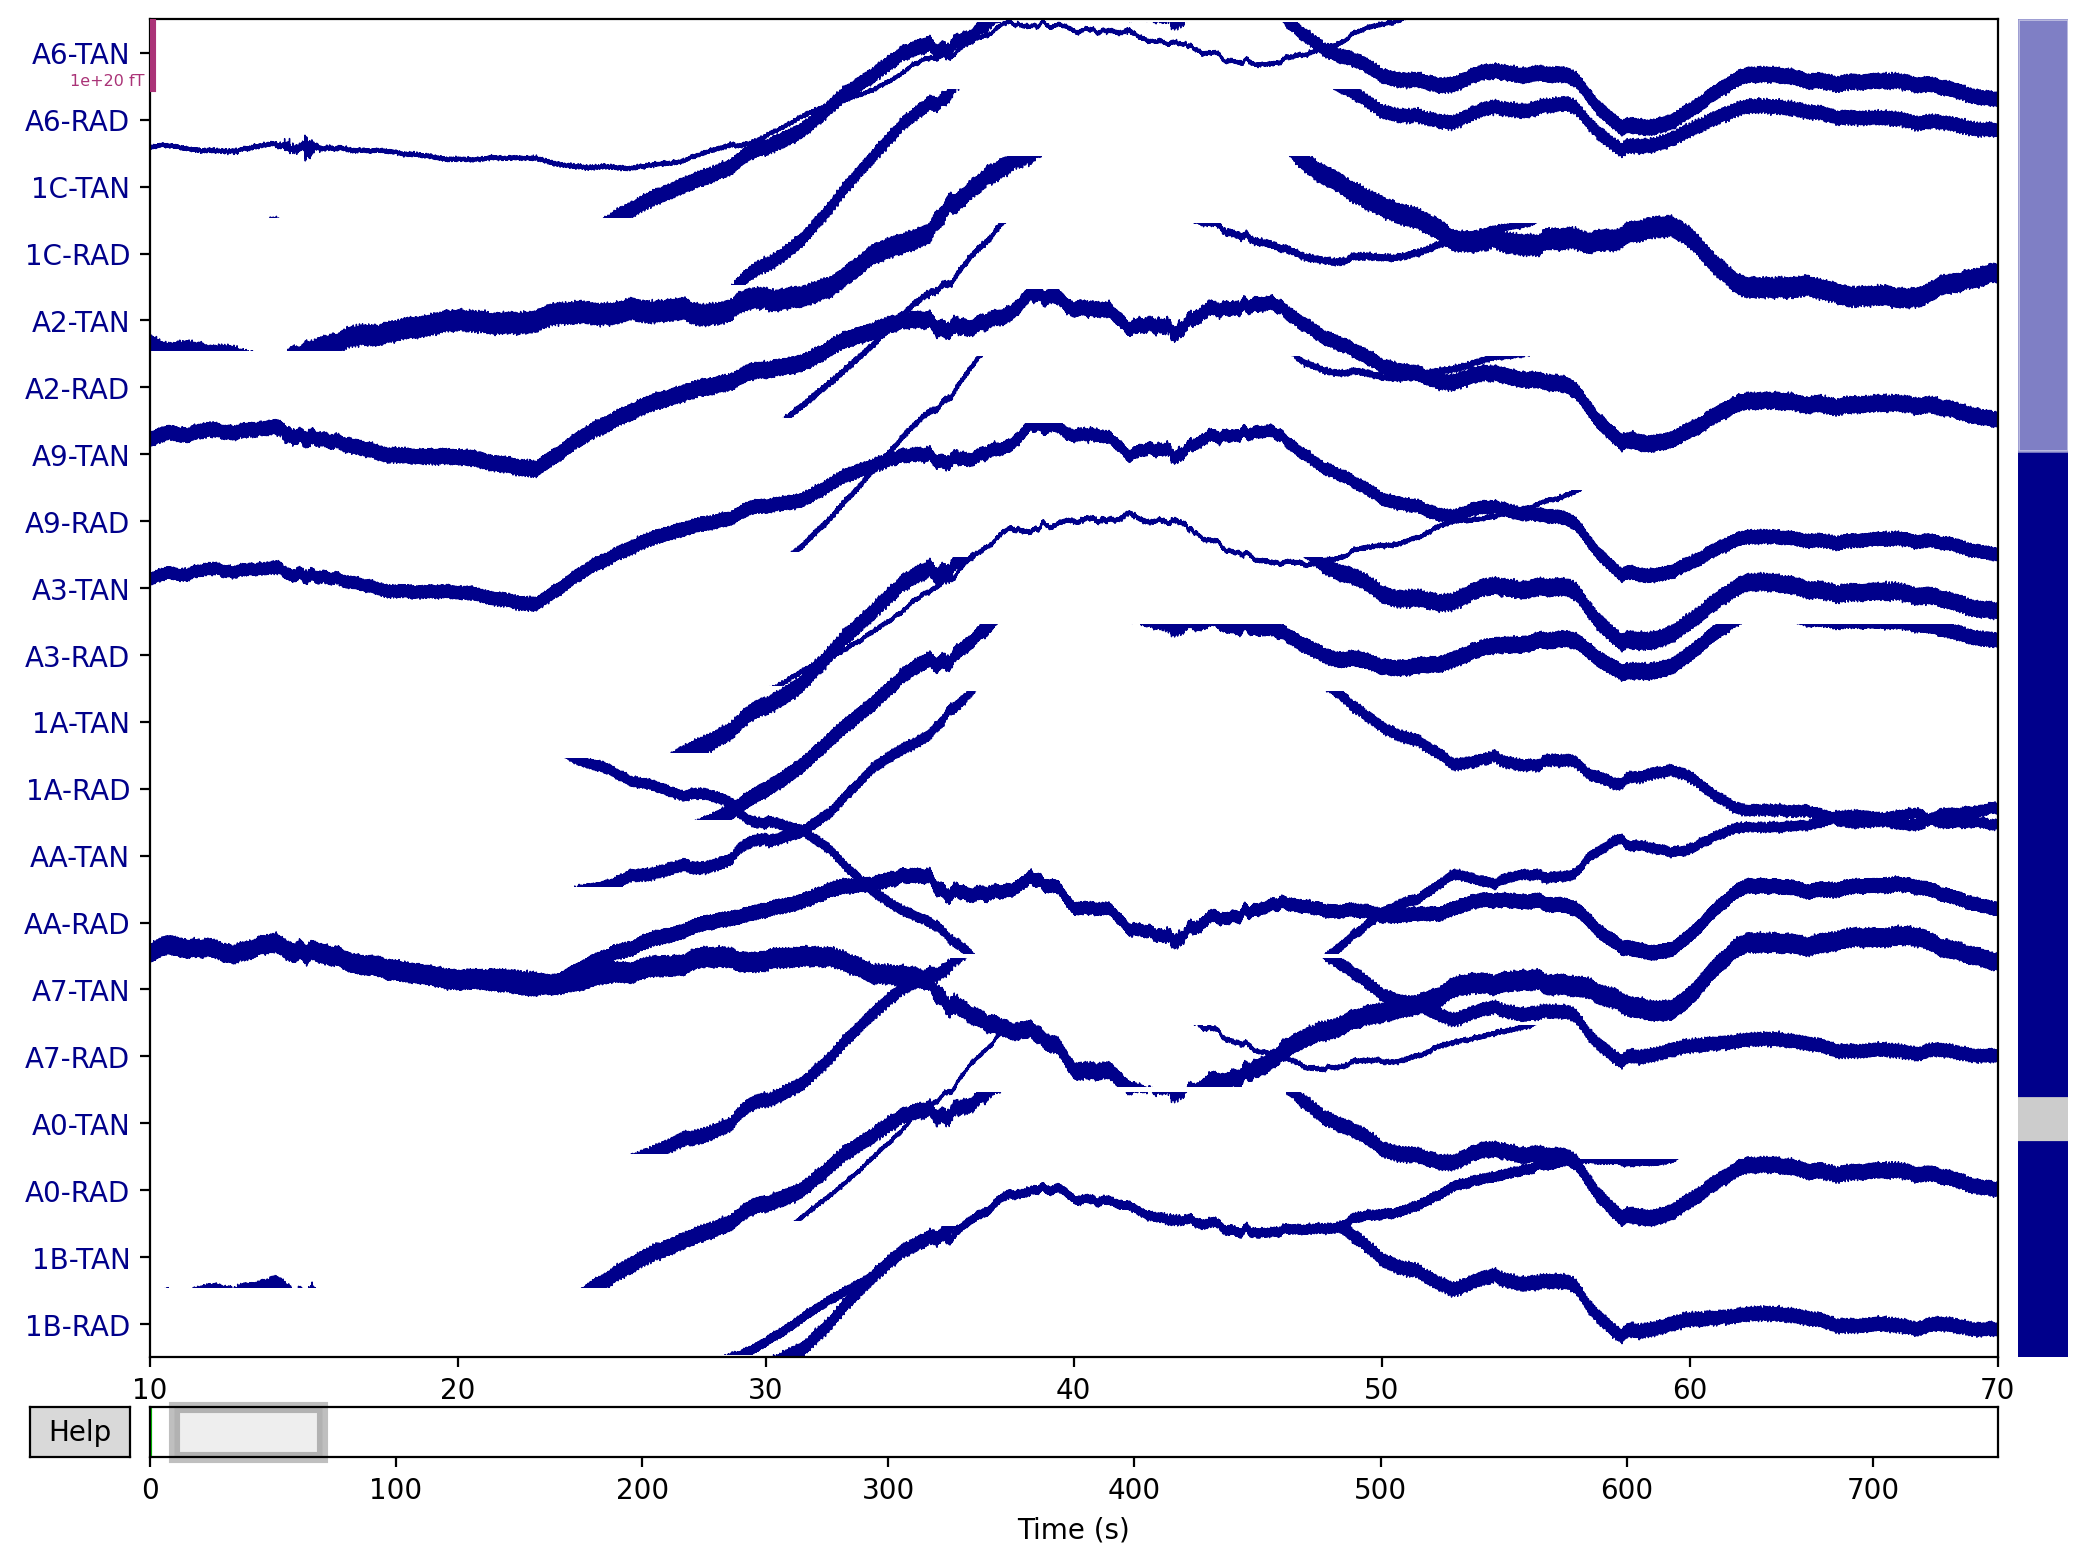

In [48]:
raw_mag.plot(scalings = 5e4, start=10.0,duration = 60)


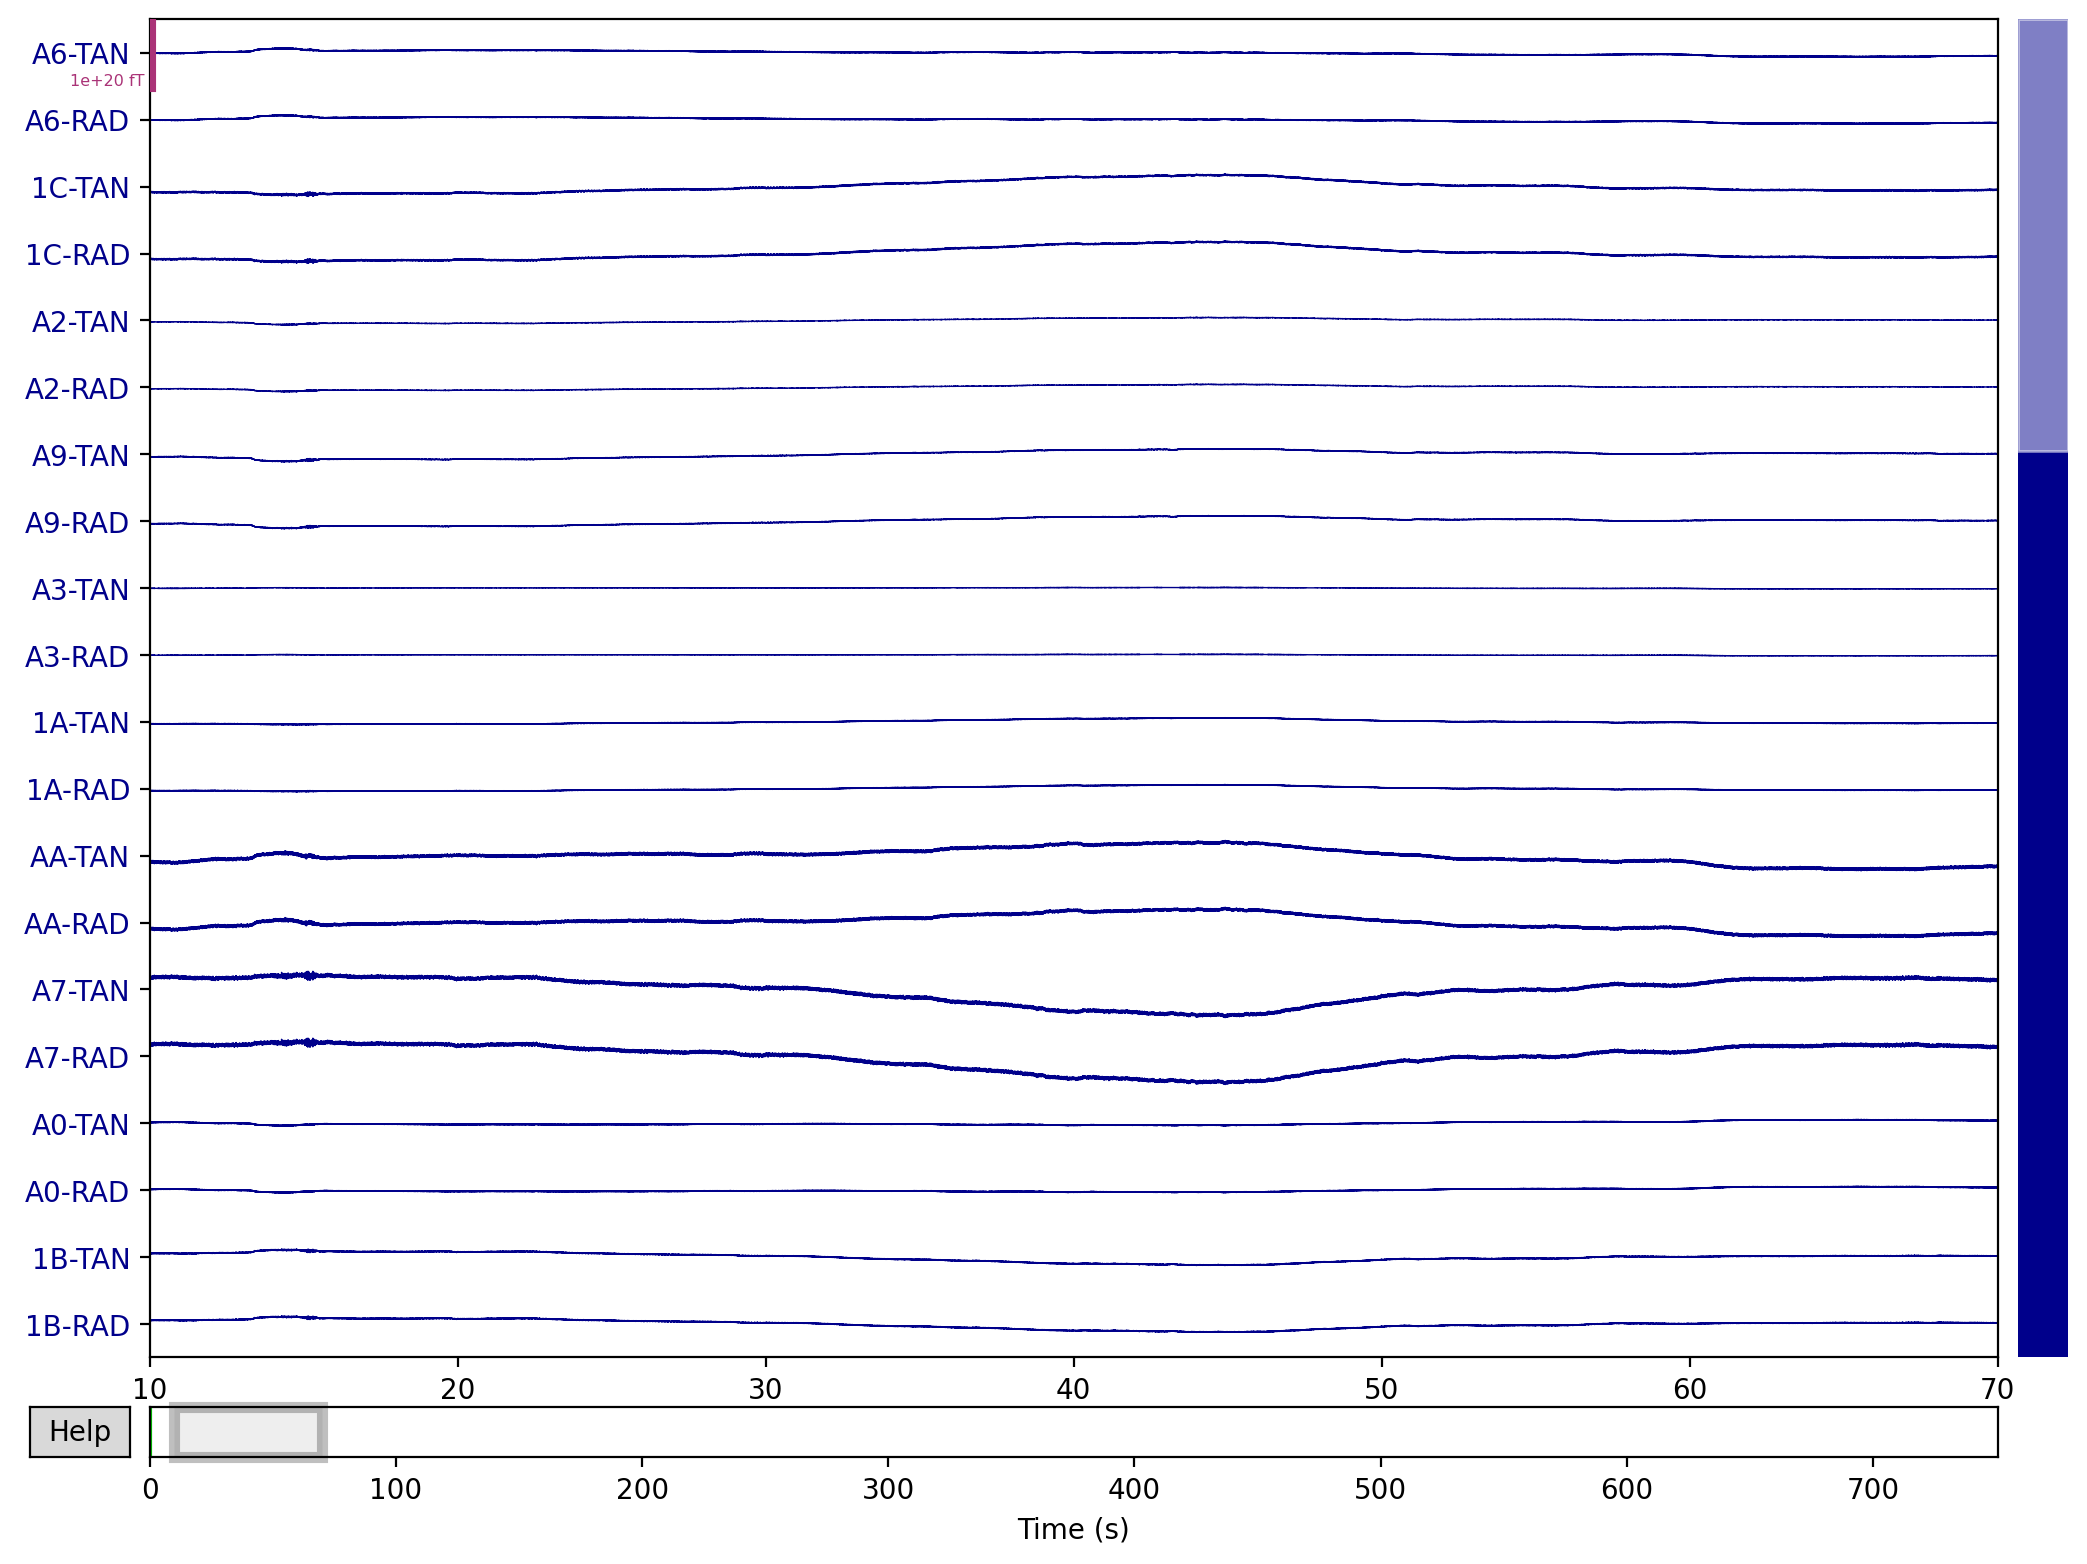

In [51]:
raw_mag_sss.plot(scalings = 5e4, start=10.0,duration = 60)

In [52]:
# save 150s of MEG data in FIF file
raw_mag_sss.save('MMF_tSSS_raw.fif',
         overwrite=True)

Overwriting existing file.
Writing /Users/rseymoue/Documents/GitHub/analyse_OPMEG/test_scripts/MMF_tSSS_raw.fif
Closing /Users/rseymoue/Documents/GitHub/analyse_OPMEG/test_scripts/MMF_tSSS_raw.fif [done]


Effective window size : 10.000 (s)


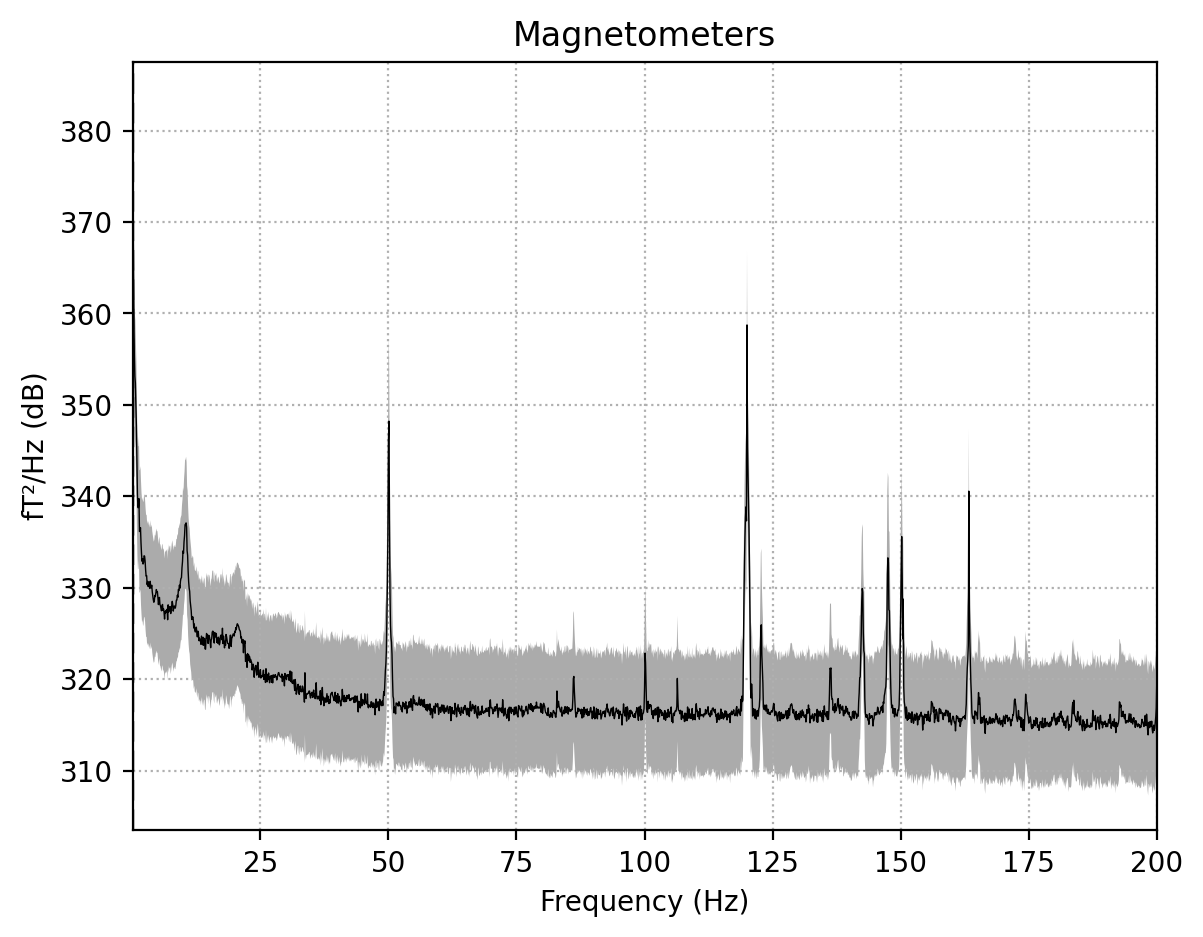

In [50]:
raw_mag_sss.plot_psd(average=True,fmin=0.1,fmax=200,n_fft=6000)

In [100]:
raw_mag_sss = raw_mag_sss.notch_filter(np.arange(50, 251, 50),notch_widths=2)
raw_mag_sss = raw_mag_sss.notch_filter(120,notch_widths=2)
raw_mag_sss = raw_mag_sss.filter(l_freq=2, h_freq=40)


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3961 samples (6.602 sec)

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 118.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 118.25 Hz)
- Upper passband edge: 121.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 121.75 Hz)
- Filter length: 3961 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 40 Hz



In [25]:
raw_spare = load_UCL_OPM(raw_name, chan_name, chan_json, pos_file)

Data loaded as: >f4
Creating RawArray with float64 data, n_channels=77, n_times=4504140
    Range : 0 ... 4504139 =      0.000 ...   750.690 secs
Ready.


In [149]:
# raw_mag_sss.add_proj(ssp1, remove_existing=True)

3 projection items deactivated


<RawArray | 62 x 4504140 (750.7 s), ~2.08 GB, data loaded>

In [26]:
events = mne.find_events(raw_spare, stim_channel='NI-TRIG',uint_cast=True,min_duration=0.1)
events[:,0] = events[:,0]/10

events

1449 events found
Event IDs: [5]


array([[  9153,      0,      5],
       [  9456,      0,      5],
       [  9759,      0,      5],
       ...,
       [447871,      0,      5],
       [448175,      0,      5],
       [448478,      0,      5]])

In [101]:
# Compute epochs
tmin, tmax, event_id = -0.2, 0.5, 5 

epochs = mne.Epochs(raw_mag_sss, events, event_id, tmin, tmax,
                    baseline=(-0.2, 0), preload=True)

Not setting metadata
Not setting metadata
1449 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1449 events and 421 original time points ...
0 bad epochs dropped


In [102]:
# compute evoked
evoked = epochs.average()

<ipython-input-103-2b60c9e0d4dc>:1: RuntimeWarning: (X, Y) fit (-0.9, 22.0) more than 20 mm from head frame origin
  evoked.plot(proj=False,time_unit='s')


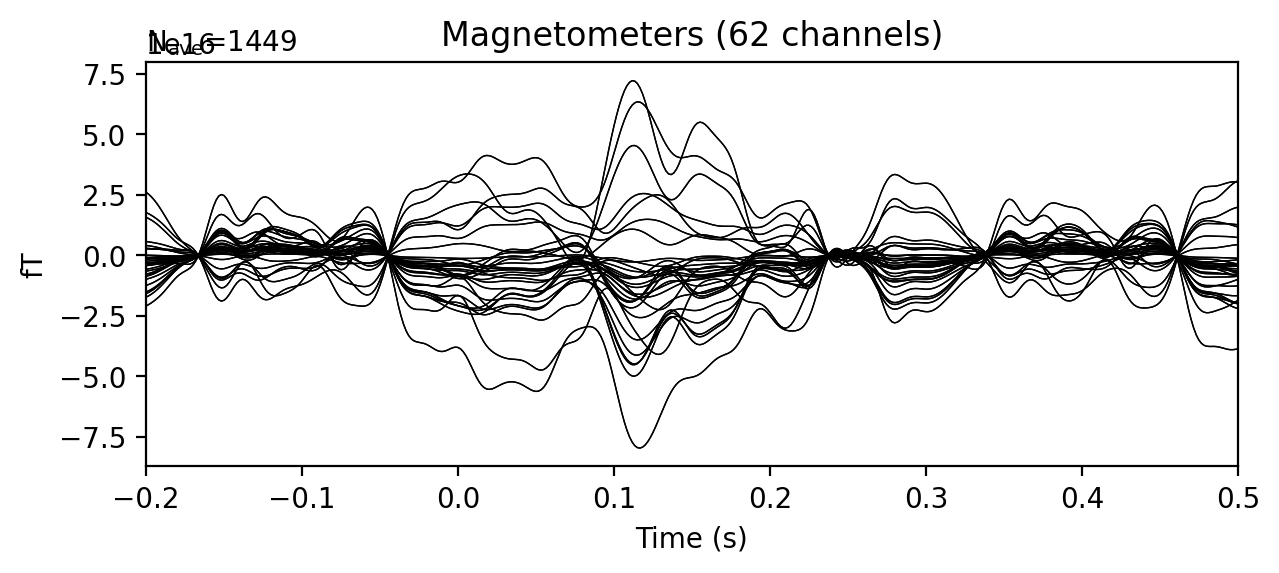

In [103]:
evoked.plot(proj=False,time_unit='s')

In [108]:
# save 150s of MEG data in FIF file
raw_mag_sss.save('MMF_tSSS_raw.fif',
         overwrite=True)

Writing /Users/rseymoue/Documents/GitHub/analyse_OPMEG/test_scripts/MMF_tSSS_raw.fif
Closing /Users/rseymoue/Documents/GitHub/analyse_OPMEG/test_scripts/MMF_tSSS_raw.fif [done]


In [107]:
bytearray(raw_mag_sss.get_data())

In [46]:
times = np.arange(0.05, 0.151, 0.02)
evoked.plot_topomap(times, ch_type='mag', time_unit='s')

<ipython-input-46-7888d56b1c06>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'DO', 'A6', 'A0', 'DP', 'A4', 'DQ', 'AA', '17', 'OF', 'DM', 'DJ', 'MW', 'MX', 'OJ', 'A9', 'DU', 'A8', '1A', 'A3', 'DS', 'OH', 'DL', '1B', 'N2', 'MZ', '19', 'A2', 'A7', 'DR', '1C', 'MT'}. Applying running numbers for duplicates.
  evoked.plot_topomap(times, ch_type='mag', time_unit='s')


ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
A6-0, A6-1, 1C-0, 1C-1, A2-0, A2-1, A9-0, A9-1, A3-0, A3-1, 1A-0, 1A-1, AA-0, AA-1, A7-0, A7-1, A0-0, A0-1, 1B-0, 1B-1, 19-0, 19-1, 17-0, 17-1, A4-0, A4-1, A8-0, A8-1, MW-0, MW-1, MX-0, MX-1, N2-0, N2-1, DO-0, DO-1, MT-0, MT-1, MZ-0, MZ-1, DS-0, DS-1, OJ-0, OJ-1, OH-0, OH-1, OF-0, OF-1, DJ-0, DJ-1, DP-0, DP-1, DL-0, DL-1, DQ-0, DQ-1, DU-0, DU-1, DM-0, DM-1, DR-0, DR-1